In [1]:
from fastkaggle import *
import timm 

In [3]:
#Precisa se registrar na competicao antes na pagina do Kaggle

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [4]:
path

Path('paddy-disease-classification')

In [5]:
from fastai.vision.all import *
set_seed(42)
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


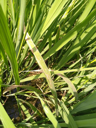

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

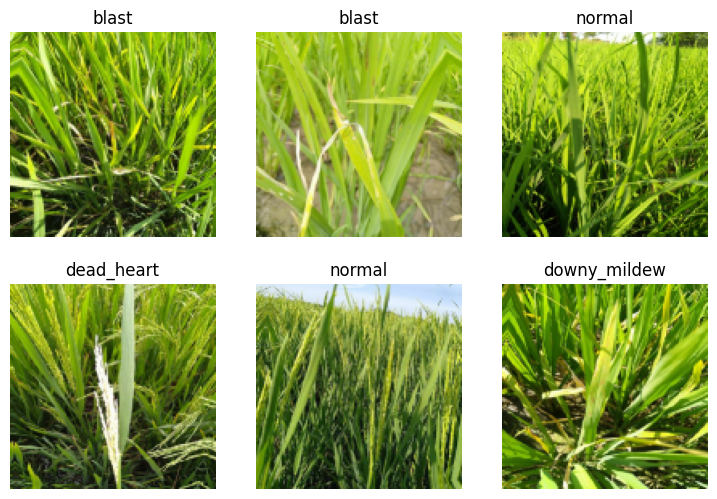

In [8]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)


In [9]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /home/scopinho/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0014454397605732083, slide=0.0020892962347716093)

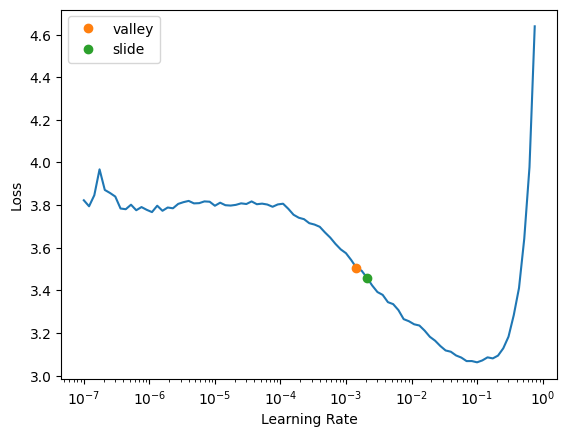

In [10]:
learn.lr_find(suggest_funcs=(valley, slide))

In [13]:
learn.fine_tune(3, 0.01)

In [14]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [15]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 7,  ..., 8, 1, 5])

In [16]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [17]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [19]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [20]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [21]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 69.9k/69.9k [00:01<00:00, 42.9kB/s]


Due to the image sizes, the learning process is too slow...let´s resize the image

In [22]:
trn_path = Path('paddy-disease-classification-small')

In [23]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

Colocando os passos do Dataloader, vision_learner, fine_tune em uma função

In [24]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

Comparando com o treinamento e resultados anteriores, a performance melhorou e a loss se manteve similar

In [25]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

In [27]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.1168)

Usando um modelo ConvNeXt

In [23]:
import gc

def report_gpu():
    #print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [22]:
print(torch.cuda.list_gpu_processes())

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [17]:
arch = 'convnext_small_in22k'

In [18]:

def train(arch, size, item=Resize(192, method='squish'), accum=2, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
    batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [24]:
report_gpu()

In [28]:

#!export PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
learn = train(arch, 128, item=Resize(128, method='squish'),accum=10, finetune=False, epochs=12)
report_gpu()

#learn = train(arch, item=Resize(192, method='squish'),
#batch=aug_transforms(size=128, min_scale=0.75))

Output()

KeyboardInterrupt: 

In [21]:
report_gpu()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

Testando outras estratégias de pre-processamento, ao invés de "squished", vamos fazer um "crop"

In [ ]:
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

Como não pareceu ter muita diferença, vamos usar um padding aterando o Dataloader sem transforacao

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [ ]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

Verfificando predições e error rate antes de aplicar o TTA (Test Time Augumentation)

In [25]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

AttributeError: 'NoneType' object has no attribute 'dls'

In [26]:
learn.dls.train.show_batch(max_n=6, unique=True)

AttributeError: 'NoneType' object has no attribute 'dls'

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

Verificando o error rate após o TTA

In [ ]:
error_rate(tta_preds, targs)

Escalando o processo, voltando a usar as imagens maiores e rodando com 12 epochs

In [ ]:
trn_path = path/'train_images'

In [ ]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

Agora vamos aplicar o TTA neste modelo maior

In [ ]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

Submetendo o modelo

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [ ]:
preds,_ = learn.tta(dl=tst_dl)

In [ ]:
idxs = preds.argmax(dim=1)

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'convnext small 256x192 12 epochs tta', comp)